In [48]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
import glob
from matplotlib.colors import LogNorm

from cycler import cycler

colors = plt.cm.Dark2.colors
plt.rc('axes', prop_cycle=cycler('color', colors))

In [49]:
# Load in the pmaps from the data

pmaps_data = load_pmaps_as_df("../data/run_13837_0000_ldc1_trg0_irene.h5")

s1_pmaps_data = pmaps_data[0]
s2_pmaps_data = pmaps_data[1]

# want event 37
display(s1_pmaps_data)

,event,peak,time,bwidth,ene
0,9,0,370850.0,25.0,0.582687
1,9,0,370875.0,25.0,0.681323
2,9,0,370900.0,25.0,1.158818
3,9,0,370925.0,25.0,1.529265
4,9,0,370950.0,25.0,1.262709
...,...,...,...,...,...
9591,464,0,513450.0,25.0,0.537632
9592,464,0,513475.0,25.0,0.632251
9593,464,0,513500.0,25.0,0.395579
9594,464,0,513525.0,25.0,0.398330


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_19973/3799484825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1s_data["time"] = s1s_data["time"] -960.75e3
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_19973/3799484825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2s_data["time"] = s2s_data["time"] -960.75e3


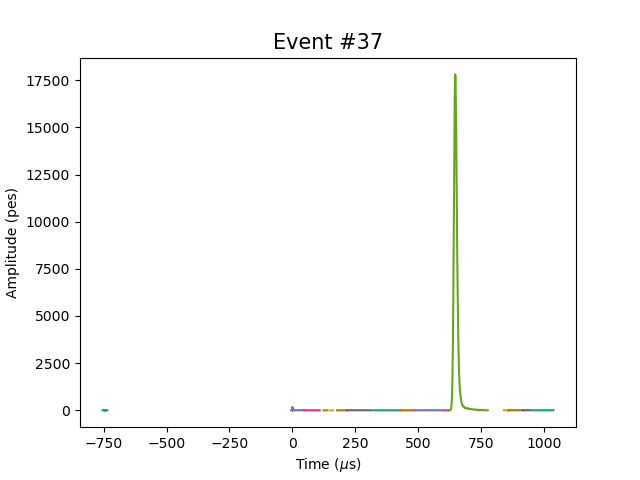

In [50]:
s1s_data, s2s_data, s2sis, s1pmts, s2pmts = pmaps_data
s1s_data   = s1s_data  .loc[lambda df: df.event == 37]
s2s_data   = s2s_data  .loc[lambda df: df.event == 37]
s2sis = s2sis.loc[lambda df: df.event == 37]

s1s_data["time"] = s1s_data["time"] -960.75e3
s2s_data["time"] = s2s_data["time"] -960.75e3

plt.figure()

for _, s1 in s1s_data.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


for _, s2 in s2s_data.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice


# plt.plot(s1s_data[s1s_data.peak == 23].time / 1e3, s1s_data[s1s_data.peak == 23].ene)
# plt.plot(s2s[s2s.peak == 10].time / 1e3, s2s[s2s.peak == 10].ene)

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.title(f"Event #{37}", fontsize=15);

# plt.xlim(-1,1)

In [143]:
# Load in the MC
mc_labels = ["nexus", "garfnexus", "imp_zsquared", "imp_rsquared","imp_rsquared_v2"]
pmaps_mc = []
s1_pmaps_mc = []
s2_pmaps_mc = []

for idx,label in enumerate(mc_labels):
    pmaps_mc.append(load_pmaps_as_df(f"../data/NEXT100_Ar_alpha_5.6MeV_{label}_hypathia.h5"))
    s1_pmaps_mc.append(pmaps_mc[idx][0].loc[lambda df: df.event == 0])
    s2_pmaps_mc.append(pmaps_mc[idx][1].loc[lambda df: df.event == 0])

    s1_pmaps_mc[idx]["time"] = s1_pmaps_mc[idx]["time"]-10e3
    s2_pmaps_mc[idx]["time"] = s2_pmaps_mc[idx]["time"]-10e3



Text(0, 0.5, 'Amplitude (pes)')

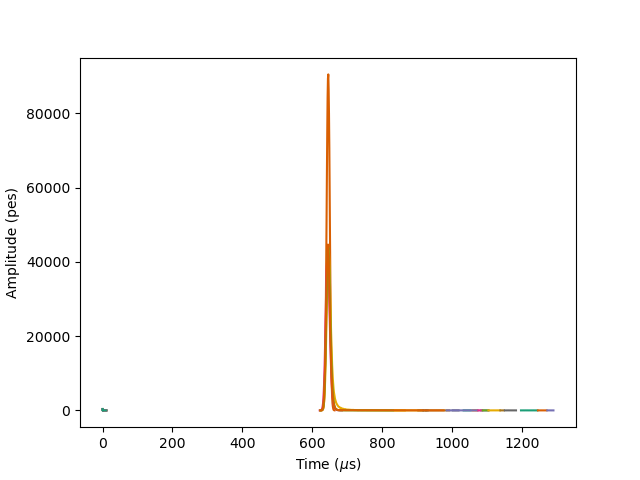

In [144]:
%matplotlib widget


for idx,label in enumerate(mc_labels):

    for _, s1 in s1_pmaps_mc[idx].groupby("peak"):
        plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


    for _, s2 in s2_pmaps_mc[idx].groupby("peak"):
        plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice


plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")

(620.0, 900.0)

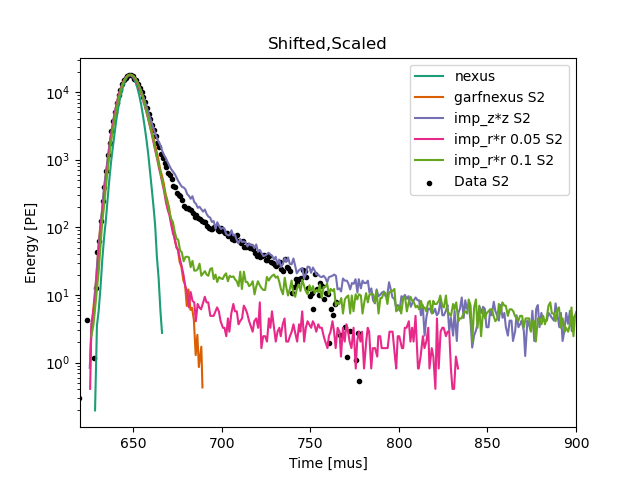

In [152]:
plt.figure()

mc_s2_labels = ["nexus","garfnexus S2", "imp_z*z S2", "imp_r*r 0.05 S2", "imp_r*r 0.1 S2"]
mc_timeshifts = [3,4.8,2,3,4]
mc_sf = [0.24,0.525,0.51,0.5,0.5]


# plt.plot(s1s_data[s1s_data.peak == 23].time / 1e3, s1s_data[s1s_data.peak == 23].ene, label = "Data S1")
plt.scatter(s2s_data[s2s_data.peak == 10].time / 1e3, s2s_data[s2s_data.peak == 10].ene, label = "Data S2", marker=".", c="k")

for idx,label in enumerate(mc_labels):

    # plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC S1 x49/60")
    plt.plot( (s2_pmaps_mc[idx][s2_pmaps_mc[idx].peak == 0].time / 1e3+ mc_timeshifts[idx]), s2_pmaps_mc[idx][s2_pmaps_mc[idx].peak == 0].ene*49/60*mc_sf[idx], label = mc_s2_labels[idx])


    # plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC Simp S1 x49/60")
    # plt.plot(s2s_mc_simple[s2s_mc_simple.peak == 0].time / 1e3+2, s2s_mc_simple[s2s_mc_simple.peak == 0].ene*49/60*0.5, label = "MC S2 (Garf Nexus)\n Scaled,shifted,impur model")



plt.legend()

plt.title("Shifted,Scaled")
plt.xlabel("Time [mus]")
plt.ylabel("Energy [PE]")
plt.semilogy()
plt.xlim(620, 900)


(620.0, 700.0)

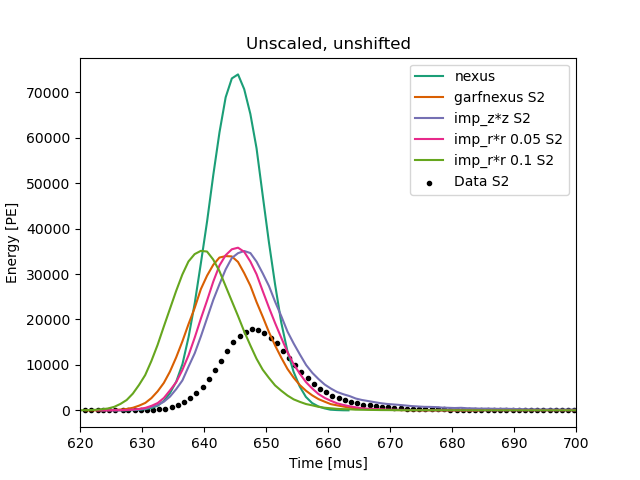

In [142]:
plt.figure()

mc_s2_labels = ["nexus","garfnexus S2", "imp_z*z S2", "imp_r*r 0.05 S2", "imp_r*r 0.1 S2"]


# plt.plot(s1s_data[s1s_data.peak == 23].time / 1e3, s1s_data[s1s_data.peak == 23].ene, label = "Data S1")
plt.scatter(s2s_data[s2s_data.peak == 10].time / 1e3, s2s_data[s2s_data.peak == 10].ene, label = "Data S2", marker=".", c="k")

for idx,label in enumerate(mc_labels):

    # plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC S1 x49/60")
    plt.plot( (s2_pmaps_mc[idx][s2_pmaps_mc[idx].peak == 0].time / 1e3), s2_pmaps_mc[idx][s2_pmaps_mc[idx].peak == 0].ene*49/60, label = mc_s2_labels[idx])


    # plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC Simp S1 x49/60")
    # plt.plot(s2s_mc_simple[s2s_mc_simple.peak == 0].time / 1e3+2, s2s_mc_simple[s2s_mc_simple.peak == 0].ene*49/60*0.5, label = "MC S2 (Garf Nexus)\n Scaled,shifted,impur model")



plt.legend()

plt.title("Unscaled, unshifted")
plt.xlabel("Time [mus]")
plt.ylabel("Energy [PE]")
# plt.semilogy()
plt.xlim(620, 700)

Text(0, 0.5, 'Energy [PE]')

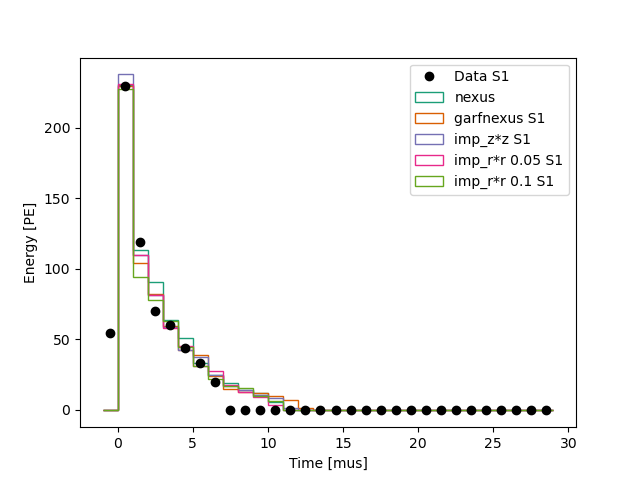

In [141]:
plt.figure()

# plt.scatter(s2s_data[s2s_data.peak == 10].time / 1e3, s2s_data[s2s_data.peak == 10].ene, label = "Data S2", marker=".", c="k")

counts, bin_edges = np.histogram(s1s_data[s1s_data.peak == 1].time / 1e3, weights = s1s_data[s1s_data.peak == 1].ene,bins = np.arange(-1,30,1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, counts, 'ko', label = "Data S1")  # 'ro' stands for red circles

# plt.hist(s1s_data[s1s_data.peak == 1].time / 1e3, weights = s1s_data[s1s_data.peak == 1].ene, label = "Data S1", histtype ="step", bins = np.arange(-1,30,1))

mc_s1_labels = ["nexus","garfnexus S1", "imp_z*z S1", "imp_r*r 0.05 S1", "imp_r*r 0.1 S1"]
mc_timeshifts = [3,4.8,2,3,8]
mc_sf = [0.28,0.26,0.26,0.26,0.26]

for idx,label in enumerate(mc_labels):

    plt.hist(s1_pmaps_mc[idx][s1_pmaps_mc[idx].peak == 0].time / 1e3,      weights = s1_pmaps_mc[idx][s1_pmaps_mc[idx].peak == 0].ene*49/60*mc_sf[idx], label = mc_s1_labels[idx], histtype ="step", bins = np.arange(-1,30,1))

plt.legend()

plt.xlabel("Time [mus]")
plt.ylabel("Energy [PE]")